<a href="https://colab.research.google.com/github/nagusubra/ENDG511_Labs/blob/main/Lab3/ENDG511_LAB_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **ENDG 511 Lab 3 Assignment: Model Pruning and Quantization**

This colab notebook provides code and a framework for ***Lab 3***. You can work out your solutions here.


## Goals

In this lab, you will be introduced to different model optimization methods using TensorFlow and Keras, and you will learn how to use them to create efficient deep learning models. The goals of this lab are:

- Understand the basics of pruning and quantization.
- Apply pruning and quantization to an MNIST model.
- Understand and use TFLite.
- Evaluate models in terms of accuracy, size and inference time.
- Understand how different pruning and quantization parameters can impact accuracy, size and inference time.
- Apply collaborative optimization by combining pruning and quantization.

## Layout
This lab is split into **three** parts. 
- **Part 1**: Apply pruning to an MNIST model and evaluate the pruned model.
- **Part 2**: Apply post-training quantization and evaluate the quantized model.
- **Part 3**: Combine pruning and post-training quantization and evaluate the final model.

## How to submit the Assignment 

- You are required to sumbmit the completed python notebook and a **pdf version** of it in a Dropbox folder on D2L.
- This is an individual assignment, and all the assignements must be submitted individually.
- This assignment can be completed directly on Google Colab, but you are free to choose any other computing resource. 
-  Lab sessions will be held to go over the main concepts and help you with the assignment.

- **Due Date: 17th February 2023**

# **Part 1**: Pruning

This part of the lab demonstrates applying pruning to a neural network to reduce size and inference while maintaining a similar accuracy to the original neural network. At a high level, the steps required to prune and evaluate a model are as follows:

- Build and train the dense baseline
- Prune model
- Fine-tune pruned model
- Evaluate the model

There are different types of pruning techniques, the technique demonstrated in this lab is magnitude-based weight pruning (also referred to as unstructured pruning). Magnitude-based weight pruning gradually zeroes out model weights based on their importance during the training process to achieve model sparsity. Sparse models are easier to compress, and we can skip the zeroes during inference for latency improvements. The image below can help you visualize pruning:

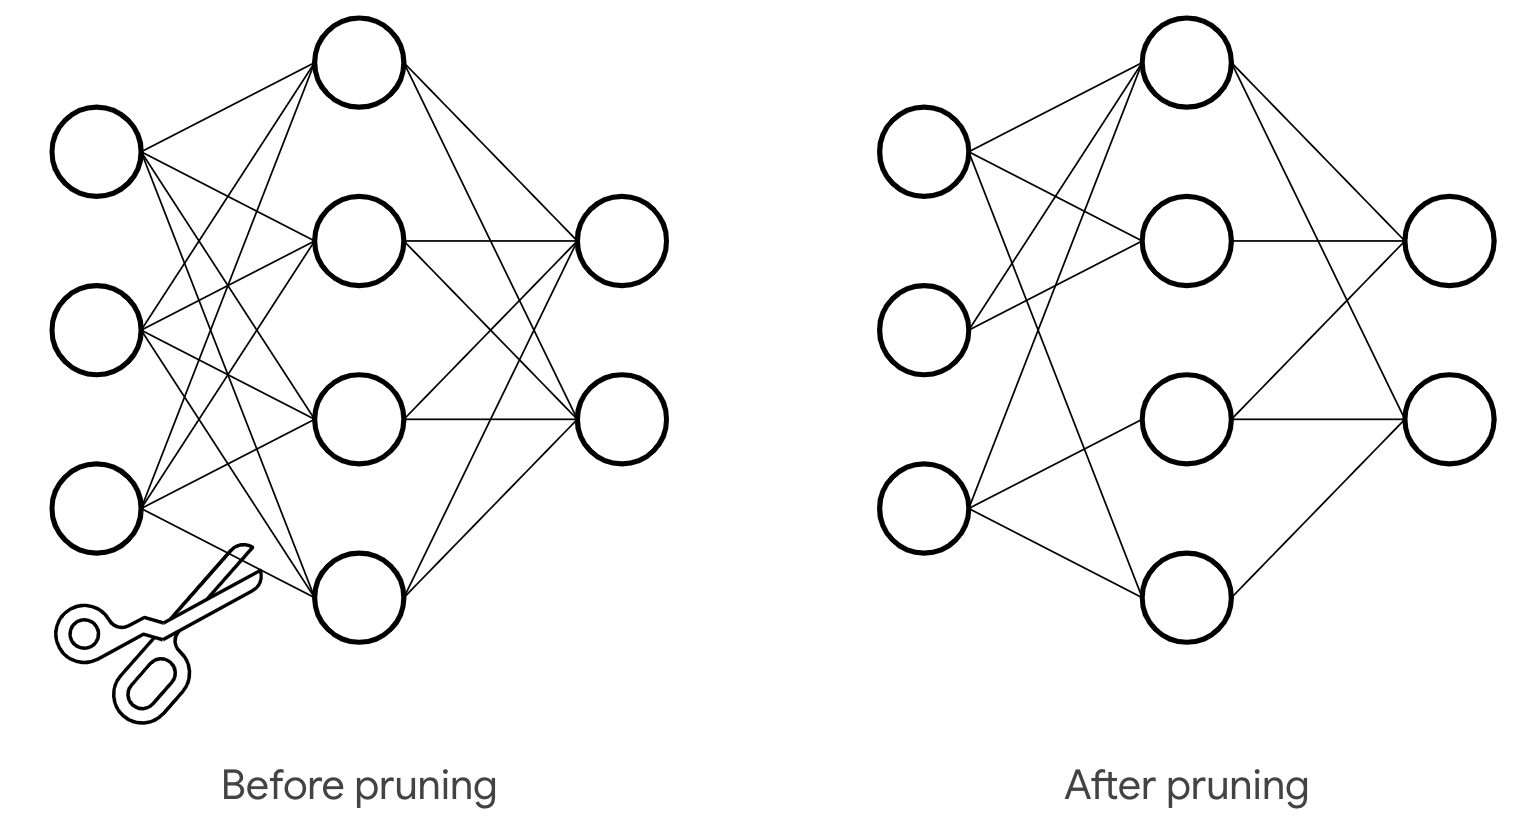

### Import and install all required modules

In [1]:
!pip install -q tensorflow-model-optimization

import tempfile
import os
import time

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow_model_optimization as tfmot

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.9/238.9 KB 11.7 MB/s eta 0:00:00


### Build and Train a neural network for MNIST without pruning

Similar to the examples presented in Lab1 we will build and train a neural network for the MNIST dataset without any model optimization. This will be our base model for the remainder of this lab. We also save the model before training.


In [ ]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

# Define the model architecture.
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])

# Save untrained model
model.save('untrained_base_model.h5')

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
model.fit(
  train_images,
  train_labels,
  epochs=5,
  validation_split=0.1,
)

11490434/11490434 [==============================] - 2s 0us/step


Epoch 1/5
1688/1688 [==============================] - 7s 3ms/step - loss: 0.3116 - accuracy: 0.9090 - val_loss: 0.1241 - val_accuracy: 0.9662
Epoch 2/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1520 - accuracy: 0.9546 - val_loss: 0.0998 - val_accuracy: 0.9700
Epoch 3/5
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1151 - accuracy: 0.9654 - val_loss: 0.0833 - val_accuracy: 0.9732
Epoch 4/5
1688/1688 [==============================] - 4s 3ms/step - loss: 0.0920 - accuracy: 0.9711 - val_loss: 0.0754 - val_accuracy: 0.9743
Epoch 5/5
1688/1688 [==============================] - 6s 3ms/step - loss: 0.0785 - accuracy: 0.9759 - val_loss: 0.0723 - val_accuracy: 0.9793


Let's display the architecture of our model:

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Save model
Let us save the trained model so that we can evaluate at a later stage.

In [ ]:
# Save your trained model
model.save('trained_base_model.h5')

### Prune the dense model
We will create a pruned model from our original model. We will force the model to have 50% sparsity (50% of the weights are zeroed out). Finally we recompile our new pruned model.

Note: ConstantSparsity performs "one-shot" magnitude based pruning of all the layers. There are more advanced techniques but this is the simplest one. The total number of parameters increases because tensorflow adds a "pruning wrapper" to all parameters, this gets stripped at a later stage.

In [ ]:
prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
## Print weights before and after

# Define model for pruning. The 0.5 is the target sparsity (50%)
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.ConstantSparsity(0.5, begin_step=0, frequency=100)
}

pruned_model = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
pruned_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

pruned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_flatten  (None, 784)              1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense (  (None, 128)              200834    
 PruneLowMagnitude)                                              
                                                                 
 prune_low_magnitude_dropout  (None, 128)              1         
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense_1  (None, 10)               2572      
  (PruneLowMagnitude)                                            
                                                                 
Total params: 203,408
Trainable params: 101,770
Non-trai

### Fine-tune pruned model
Next, we have to fine-tune our pruned model by retraining for a suitable number of epochs.
Note: tfmot.sparsity.keras.UpdatePruningStep is required as a callback during training.

In [ ]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
]

pruned_model.fit(train_images, train_labels, epochs=2, validation_split=0.1,
                  callbacks=callbacks)

Epoch 1/2
1688/1688 [==============================] - 10s 4ms/step - loss: 0.0737 - accuracy: 0.9774 - val_loss: 0.0683 - val_accuracy: 0.9798
Epoch 2/2
1688/1688 [==============================] - 6s 4ms/step - loss: 0.0599 - accuracy: 0.9810 - val_loss: 0.0635 - val_accuracy: 0.9807


### Apply strip pruning

strip_pruning is necessary since it removes every tf.Variable that pruning only needs during training, which would otherwise add to the final model size. It strips the pruning wrapper, It is also needed when converting to a TFLite model.

In [ ]:
stripped_pruned_model = tfmot.sparsity.keras.strip_pruning(pruned_model)
stripped_pruned_model.save('stripped_pruned_model.h5')

### Confirm that pruning was correctly applied

In [ ]:
def print_model_weights_sparsity(model):

    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Wrapper):
            weights = layer.trainable_weights
        else:
            weights = layer.weights
        for weight in weights:
            if "kernel" not in weight.name or "centroid" in weight.name:
                continue
            weight_size = weight.numpy().size
            zero_num = np.count_nonzero(weight == 0)
            print(
                f"{weight.name}: {zero_num/weight_size:.2%} sparsity ",
                f"({zero_num}/{weight_size})",
            )
print_model_weights_sparsity(stripped_pruned_model)

dense/kernel:0: 50.00% sparsity  (50176/100352)
dense_1/kernel:0: 50.00% sparsity  (640/1280)


### Evaluate the model
Finally, we compare the pruned model to the base model. We can see that the accuracy and inference time is comparable, however, the pruned model is much smaller in size.

Note: Pruning is capable of improving inference time significantly, however, additional libraries and modifications are needed to see inference improvements as a result of pruning (Pruning inference improvements is very hardware specific!). If you are curious you can read this paper which explains how sparse models can be used to accelerate inference (https://arxiv.org/pdf/1911.09723.pdf)

In [ ]:
# Evaluate prediction accuracy
model = tf.keras.models.load_model('trained_base_model.h5')
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=0)
test_loss_pruned_50, test_acc_pruned_50 = pruned_model.evaluate(test_images,  test_labels, verbose=0)


# Evaluate Model Size
def get_gzipped_model_size(file):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(file)

  return os.path.getsize(zipped_file)


# Evaluate Inference Time
startTime = time.time()
prediction = model.predict(test_images)
executionTime = (time.time() - startTime)/len(test_images)

startTime = time.time()
prediction = pruned_model.predict(test_images)
executionTimePruned50 = (time.time() - startTime)/len(test_images)

base_model_size = get_gzipped_model_size('untrained_base_model.h5')
## Print without stripping 
pruned_model_size = get_gzipped_model_size('stripped_pruned_model.h5')

# Print
print('\nBase Model Accuracy:', test_acc*100, '%')
print("Base Model Size: %.2f bytes" % (base_model_size))
print("Base Inference Time is", executionTime, "s")

print('\nPruned Model Accuracy:', test_acc_pruned_50*100, '%')
print("Pruned Model Size: %.2f bytes" % (pruned_model_size))
print("Pruned Inference Time is", executionTimePruned50, "s")

313/313 [==============================] - 1s 4ms/step

Base Model Accuracy: 97.71999716758728 %
Base Model Size: 374849.00 bytes
Base Inference Time is 0.00013913216590881347 s

Pruned Model Accuracy: 97.75000214576721 %
Pruned Model Size: 234705.00 bytes
Pruned Inference Time is 0.0002761888027191162 s


### Excercies: (1.5 points)


Question 1: Load the trained base model (unpruned). Prune the model with a target sparsity of 90%. Evaluate the model in terms of accuracy, model size and inference time. **(0.5 points)**

In [ ]:
# INSERT YOUR CODE HERE

Question 2: Load the trained base model (unpruned). Prune the model with a target sparsity of 10%. Evaluate the model in terms of accuracy, model size and inference time. **(0.5 points)**

In [ ]:
# INSERT YOUR CODE HERE

Question 3: Plot a bar graph to show how each metric varies at a different sparsity %ages of 0%, 10%, 30%, 50%, 70%, and 90% (3 graphs in total). **(0.5 points)**

In [ ]:
# INSERT YOUR CODE HERE

In [ ]:
# INSERT YOUR CODE HERE

In [ ]:
# INSERT YOUR CODE HERE

# **Part 2**:  Quantization
This part of the lab demonstrates applying quantization to a neural network to reduce size and inference while maintaining a similar accuracy to the original neural network. At a high level, the steps required to quantize and evaluate a model are as follows:

- Build and train the dense baseline
- Apply quantization during conversion to TFLite
- Evaluate the model

There are different quantization techniques, the technique demonstrated in this lab is post-training quantization. The main idea behind quantization is that the weights and activations can be converted to types with reduced precision, such as 16 bit floats or 8 bit integers instead of 32 bit floats which can signficantly reduce model size and inference with minimal accuracy tradeoffs.

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

A TensorFlow Lite model is represented in a special efficient portable format known as FlatBuffers (identified by the .tflite file extension). This provides several advantages over TensorFlow's protocol buffer model format such as reduced size (small code footprint) and faster inference (data is directly accessed without an extra parsing/unpacking step) that enables TensorFlow Lite to execute efficiently on devices with limited compute and memory resources.
You can find more information here: https://www.tensorflow.org/lite/guide

### Load base model
Firstly, let us load the base model we have trained earlier.

In [ ]:
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
model_to_quantize.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Convert to TFLite and apply quantization
The next step is converting the base model to a TFLite model and applying quantization through the different APIs that TFLite provides. In this example we are using 8-bit quantization, this is done by using the DEFAULT optimizer. The commented codes provide an example of how to apply 16-bit floating point quantization.

In [ ]:
# Passing the Keras model to the TFLite Converter.
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
# Setting the deault optimizer
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# To convert to 16-bit floating point for example
# converter.target_spec.supported_types = [tf.float16]
# Convert the model
quantized_tflite_model = converter.convert()

### Save TFLite model and load model into an interpeter
Firstly we save the TFLite model, this will allow us to load it into an interpreter. To perform an inference with a TensorFlow Lite model, you must run it through an interpreter. The TensorFlow Lite interpreter is designed to be lean and fast. 
You can find more information on the TFLite interpeter here: https://www.tensorflow.org/lite/guide/inference

In [ ]:
# Save TFLite Model
with open('quantized_tflite_model.tflite', 'wb') as f:
  f.write(quantized_tflite_model)
# Load model into interpeter
interpreter_quant = tf.lite.Interpreter(model_path=str('quantized_tflite_model.tflite'))
interpreter_quant.allocate_tensors()

### Evaluate the model
Finally, we evaluate the quantized model in terms of accuracy, inference time and model size.

In [ ]:
# A helper function to evaluate the TF Lite model using "test" dataset.
def evaluate_model(interpreter, model_path):
  input_index = interpreter.get_input_details()[0]["index"]
  output_index = interpreter.get_output_details()[0]["index"]

  # Run predictions on every image in the "test" dataset.
  prediction_digits = []
  for test_image in test_images:
    # Pre-processing: add batch dimension and convert to float32 to match with
    # the model's input data format.
    test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
    interpreter.set_tensor(input_index, test_image)

    # Run inference.
    startTime = time.time()
    interpreter.invoke()
    executionTime = (time.time() - startTime)/len(test_images)

    # Post-processing: remove batch dimension and find the digit with highest
    # probability.
    output = interpreter.tensor(output_index)
    digit = np.argmax(output()[0])
    prediction_digits.append(digit)

  # Compare prediction results with ground truth labels to calculate accuracy.
  accurate_count = 0
  for index in range(len(prediction_digits)):
    if prediction_digits[index] == test_labels[index]:
      accurate_count += 1
  accuracy = accurate_count * 1.0 / len(prediction_digits)

  model_size = get_gzipped_model_size(model_path)
  # Print
  print('\nModel Accuracy:', accuracy*100, '%')
  print("Model Size: %.2f bytes" % (model_size))
  print("Inference Time is", executionTime, "s")
  return accuracy, model_size, executionTime

evaluate_model(interpreter_quant, 'quantized_tflite_model.tflite')


Model Accuracy: 97.68 %
Model Size: 83274.00 bytes
Inference Time is 1.0251998901367188e-09 s


(0.9768, 83274, 1.0251998901367188e-09)

### Exercise (0.5 points)

Question 1: Load the base model and apply 16 bit floating point quantization. Use the TFLite interpeter to evaluate your model. **(0.5 points)**

In [ ]:
# INSERT YOUR CODE HERE
model_to_quantize = tf.keras.models.load_model('trained_base_model.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model_to_quantize)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_types = [tf.float16]
fp16_quantized_tflite_model = converter.convert()

with open('fp16_quantized_tflite_model.tflite', 'wb') as f:
  f.write(fp16_quantized_tflite_model)
interpreter_fp16_quant = tf.lite.Interpreter(model_path=str('fp16_quantized_tflite_model.tflite'))
interpreter_fp16_quant.allocate_tensors()

evaluate_model(interpreter_fp16_quant, 'fp16_quantized_tflite_model.tflite')


Model Accuracy: 97.72 %
Model Size: 189955.00 bytes
Inference Time is 9.298324584960937e-10 s


(0.9772, 189955, 9.298324584960937e-10)

# Part 3: Collaborative Optimization



### Exercise 
Question 1 (2 points): Using the knowledge from part 1 and part 2, jointly apply pruning and post-training quantization to the base MNIST model. 

Try the following combinations and plot 3 graphs (one for each metric of accuracy, model size , and inference time):

- no pruning, no quantization
- no pruning, fp16 quantization
- no pruning, 8-bit quantization

- 10% sparsity, no quantization
- 10% sparsity, fp16 quantization
- 10% sparsity, 8-bit quantization

- 50% sparsity, no quantization
- 50% sparsity, fp16 quantization
- 50% sparsity, 8-bit quantization

- 90% sparsity, no quantization
- 90% sparsity, fp16 quantization
- 90% sparsity, 8-bit quantization

To do this, write a prune_and_quantize function and loop over different sparsities and then append all the results into 3 different arrays (one for each metric).

For example the function definition could look like this:

**def prune_and_quantize(model, target_sparsity, fp16: bool, path_to_save)**

Hint: Below is an example of how you can graph your results using matplotlib
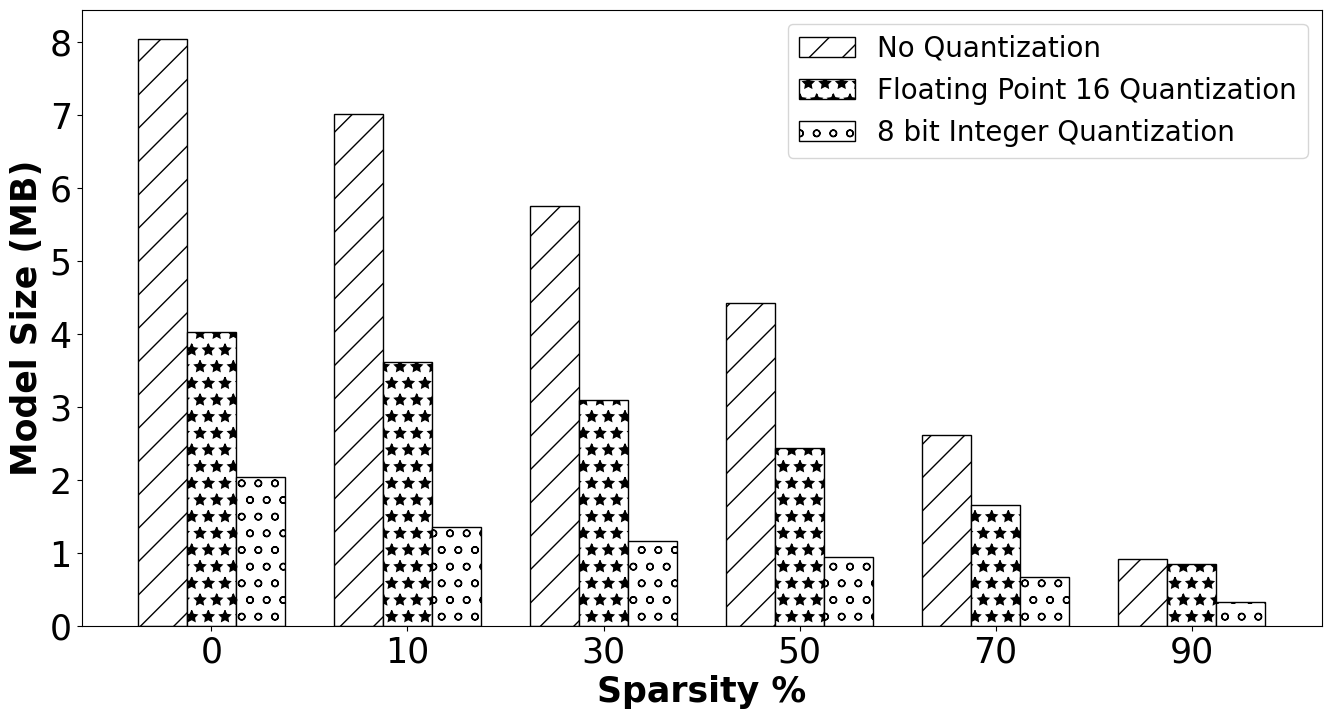

Question-2 (1 point) Redo question 1 above (using the funnction that you wrote) but this time using the CNN model that you proposed in Lab-1 Q4 as the base model. Discuss the trade-offs obtained between accuracy and model size as a function of pruning level and quantization. This time, also plot the histrogram of weights (a particular layer or all over them combined) for at least 2 different pruning levels (sample code for this is shown under visualize pruning. Does the histogram of pruned weights give any insights on the accuracy observed?

In [ ]:
# INSERT YOUR CODE HERE

In [ ]:
# INSERT YOUR PLOT CODE HERE

In [ ]:
# INSERT YOUR PLOT CODE HERE

In [ ]:
# INSERT YOUR PLOT CODE HERE

# Bonus: Visualize Pruning
In this section we will graph a small subset of the weights at different levels of pruning. The graphs clearly show how different sparsity levels affect the number of zero weights, it also shows that our pruning is unstructured.

We also provide histograms of the weights before and after pruning.

Note: Make sure you have saved the tflite files with the same names used below, alternatively you can change the model path with your correct file name. The first visualization relies on files collected from the exercise in PART 3!

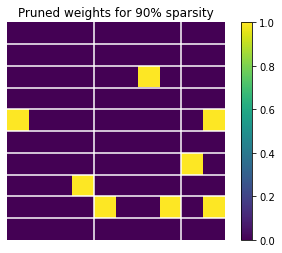

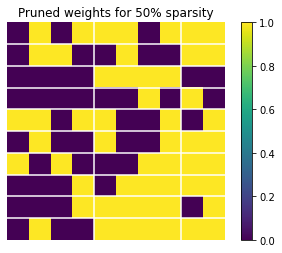

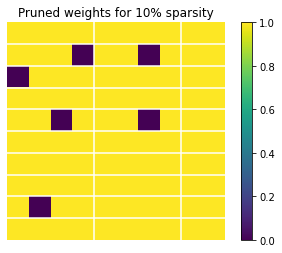

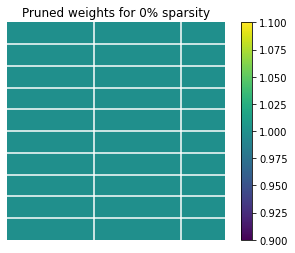

In [ ]:
def get_tensor_data(model_path):
  # Load tflite file with the created pruned model
  interpreter = tf.lite.Interpreter(model_path=model_path)
  interpreter.allocate_tensors()

  details = interpreter.get_tensor_details()

  # Weights of the dense layer that has been pruned.
  tensor_name = 'sequential/dense_1/MatMul'
  detail = [x for x in details if tensor_name in x["name"]]

  # We need the first layer.
  tensor_data = interpreter.tensor(detail[0]["index"])()
  return tensor_data

# The value 10 is chosen for convenience.
width = height = 10


def plot_separation_lines(height, width):

    block_size = [1, 4]

    # Add separation lines to the figure.
    num_hlines = int((height - 1) / block_size[0])
    num_vlines = int((width - 1) / block_size[1])
    line_y_pos = [y * block_size[0] for y in range(1, num_hlines + 1)]
    line_x_pos = [x * block_size[1] for x in range(1, num_vlines + 1)]

    for y_pos in line_y_pos:
        plt.plot([-0.5, width], [y_pos - 0.5 , y_pos - 0.5], color='w')

    for x_pos in line_x_pos:
        plt.plot([x_pos - 0.5, x_pos - 0.5], [-0.5, height], color='w')

def plot_weights_graph(tensor_data, sparsity):
  weights_to_display = tf.reshape(tensor_data, [tensor_data.shape[0],tf.reduce_prod(tensor_data.shape[1:])])
  weights_to_display = weights_to_display[0:width, 0:height]

  val_ones = np.ones([height, width])
  val_zeros = np.zeros([height, width])
  subset_values_to_display = np.where(abs(weights_to_display) > 0, val_ones, val_zeros)

  plot_separation_lines(height, width)

  plt.axis('off')
  plt.imshow(subset_values_to_display)
  plt.colorbar()
  plt.title("Pruned weights for {0}% sparsity".format(sparsity))
  plt.show()

## USE YOUR MODEL PATH
plot_weights_graph(get_tensor_data('pruned_0.9_fp16_quantized_tflite_model.tflite'), 90)
plot_weights_graph(get_tensor_data('pruned_0.5_fp16_quantized_tflite_model.tflite'), 50)
plot_weights_graph(get_tensor_data('pruned_0.1_fp16_quantized_tflite_model.tflite'), 10)
plot_weights_graph(get_tensor_data('pruned_0_fp16_quantized_tflite_model.tflite'), 0)

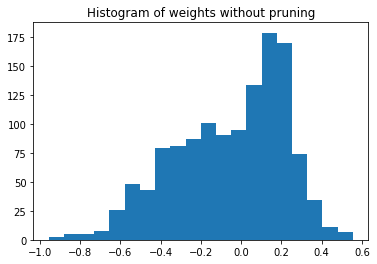

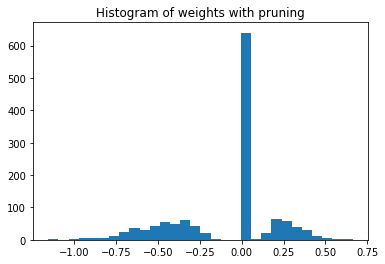

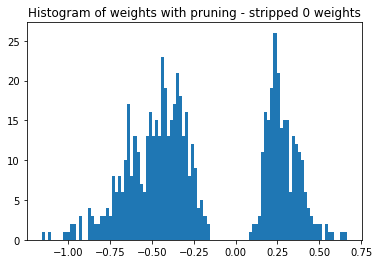

In [ ]:
## Plotting Pruning Histograms
model = tf.keras.models.load_model('trained_base_model.h5')
a = model.layers[3].weights
b = pruned_model.layers[3].weights

k = a[0].numpy().flatten()
plt.hist(k, bins = 100)
plt.title("Histogram of weights without pruning")
plt.show()

j = b[0].numpy().flatten()
plt.hist(j, bins = 100)
plt.title("Histogram of weights with pruning")
plt.show()

l = j[j != 0]
plt.hist(l, bins = 100)
plt.title("Histogram of weights with pruning - stripped 0 weights")
plt.show()